# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION

BITS ID: 2025AA05421

Name: Sagar Ganpati Powar

Email: 2025aa05421@wilp.bits-pilani.ac.in

Date: 01-02-2026

In [185]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [186]:
# For image processing
from PIL import Image
import cv2

In [187]:
# Deep learning frameworks (choose Keras or PyTorch)
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter

In [188]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


## PART 1: DATASET LOADING AND EXPLORATION

### 1.1 Dataset Selection & loading

#### 1.1.1 Load full dataset

In [189]:
full_ds = tfds.load(
    "cats_vs_dogs",
    split="train",
    as_supervised=True
)

#### 1.1.2 Create a balanced subset

In [190]:
TARGET_PER_CLASS = 1600  
TOTAL_SAMPLES = TARGET_PER_CLASS * 2 

cats = []
dogs = []

for image, label in tfds.load("cats_vs_dogs", split="train", as_supervised=True):
    if label == 0 and len(cats) < TARGET_PER_CLASS:
        cats.append((image, label))
    elif label == 1 and len(dogs) < TARGET_PER_CLASS:
        dogs.append((image, label))
        
    if len(cats) == TARGET_PER_CLASS and len(dogs) == TARGET_PER_CLASS:
        break

In [191]:
print("Cat size:", len(cats), "Dog size:", len(dogs))

Cat size: 1600 Dog size: 1600


#### 1.1.3 Combine & shuffle subset

In [192]:
import random
random.seed(42)

TRAIN_RATIO = 0.9

# Shuffle EACH class separately

random.shuffle(cats)
random.shuffle(dogs)

# Decide per-class split sizes
cat_train_size = int(TARGET_PER_CLASS * TRAIN_RATIO)   # 1440
cat_test_size  = TARGET_PER_CLASS - cat_train_size     # 160

dog_train_size = int(TARGET_PER_CLASS * TRAIN_RATIO)   # 1440
dog_test_size  = TARGET_PER_CLASS - dog_train_size     # 160

# Split EACH class separately
cats_train = cats[:cat_train_size]
cats_test  = cats[cat_train_size:]

dogs_train = dogs[:dog_train_size]
dogs_test  = dogs[dog_train_size:]

# Combine train & test sets
train_subset = cats_train + dogs_train
test_subset  = cats_test + dogs_test

random.shuffle(train_subset)
random.shuffle(test_subset)

# Convert to tf.data.Dataset
def make_dataset(subset):
    def gen():
        for image, label in subset:
            yield image, label

    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

ds_train = make_dataset(train_subset)
ds_test  = make_dataset(test_subset)

In [198]:
# Fill in these metadata fields
dataset_name = "cats_vs_dogs"
dataset_source = "Microsoft Research (Cats vs Dogs) via TensorFlow Datasets"

# Image shape
image_shape = [224, 224, 3]
problem_type = "classification"

In [199]:
# Dataset metadata (based on stratified split logic)
n_samples = TOTAL_SAMPLES
n_classes = 2

# Since split is stratified, class counts are known exactly
class_counts = {
    0: TARGET_PER_CLASS,  # Cat
    1: TARGET_PER_CLASS   # Dog
}

min_samples = min(class_counts.values())
max_samples = max(class_counts.values())
avg_samples = int(np.mean(list(class_counts.values())))

samples_per_class = (
    f"min: {min_samples}, "
    f"max: {max_samples}, "
    f"avg: {avg_samples}"
)

train_test_ratio = "90/10"
train_samples = cat_train_size + dog_train_size
test_samples  = cat_test_size + dog_test_size

print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 90/10
Training Samples: 2880
Test Samples: 320


In [200]:
class_counts[0]

1600

In [201]:
class_counts[1]

1600

In [202]:
# Primary metric selection
primary_metric = "accuracy"

metric_justification = """
The chosen Cats vs Dogs dataset is balanced, so accuracy is an appropriate primary metric that fairly represents overall model performance.
"""

In [203]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: cats_vs_dogs
Source: Microsoft Research (Cats vs Dogs) via TensorFlow Datasets
Total Samples: 3200
Number of Classes: 2
Samples per Class: min: 1600, max: 1600, avg: 1600
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: 
The chosen Cats vs Dogs dataset is balanced, so accuracy is an appropriate primary metric that fairly represents overall model performance.



### 1.2 Data Exploration and Visualization

#### 1.2.1 Show sample images

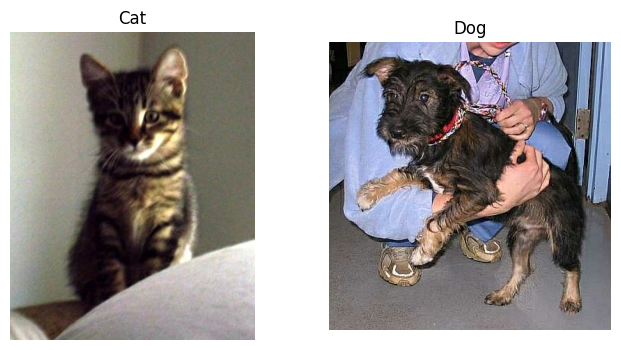

In [207]:
# Sample images from each class
class_names = ["Cat", "Dog"]

plt.figure(figsize=(8, 4))

shown = {0: False, 1: False}

for image, label in train_subset:
    label = int(label)   # ✅ convert Tensor → Python int

    if not shown[label]:
        idx = label + 1
        plt.subplot(1, 2, idx)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")
        shown[label] = True

    if all(shown.values()):
        break

plt.show()

#### 1.2.2 Class Distribution

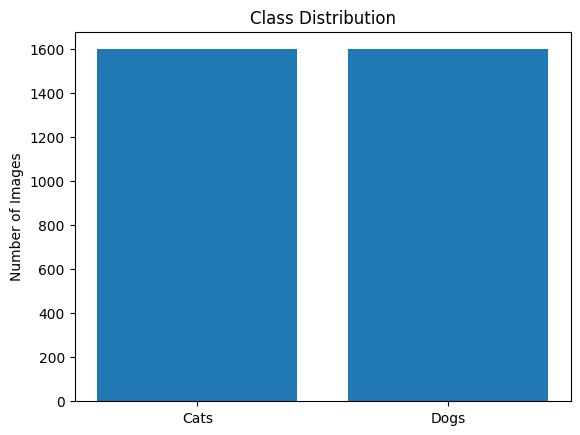

In [208]:
# Class Distribution
plt.bar(["Cats", "Dogs"], [class_counts[0], class_counts[1]])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()


In [209]:
# Image Statistics
for image, _ in subset_ds.take(1):
    print("Image Shape:", image.shape)
    print("Min Pixel Value:", tf.reduce_min(image).numpy())
    print("Max Pixel Value:", tf.reduce_max(image).numpy())

Image Shape: (500, 354, 3)
Min Pixel Value: 0
Max Pixel Value: 255


### 1.3 Data Preprocessing

#### 1.3.1 Resize images to consistent size & Normalize

In [210]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label  # label is 0 or 1 (NO one-hot)
    
train_ds = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [211]:
print("Train dataset element spec:", train_ds.element_spec)
print("Test dataset element spec:", test_ds.element_spec)

Train dataset element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
Test dataset element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


## PART 2 : Custom CNN

### 2.1 Custom CNN Architecture Design

In [212]:
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall

custom_cnn_layers_conv = 4
custom_cnn_layers_pooling = 4
custom_cnn_activation = 'sigmoid'
custom_cnn_optimizer = 'adam'
custom_cnn_loss = 'binary_crossentropy'
custom_cnn_learning_rate=0.001
custom_cnn_batch_size = 32
custom_cnn_epochs = 20


def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    
    model = models.Sequential([
        # Explicit Input layer (recommended in Keras 3.x)
        layers.Input(shape=input_shape),
        
        # First Convolution Block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolution Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Convolutional Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Global Average Pooling (MANDATORY)
        layers.GlobalAveragePooling2D(),
        
        # Output Layer
        layers.Dense(1, activation=custom_cnn_activation)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=custom_cnn_learning_rate),
        loss=custom_cnn_loss,
        metrics=['accuracy']
    )
    
    return model

In [213]:
# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)
custom_cnn.summary()
custom_cnn_total_parameters = custom_cnn.count_params()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,673 (1.48 MB)

 Trainable params: 388,673 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train Custom CNN

In [214]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()

# Train custom model
history_custom = custom_cnn.fit(train_ds, epochs=custom_cnn_epochs, validation_data=test_ds)

custom_cnn_training_time = time.time() - custom_cnn_start_time


CUSTOM CNN TRAINING
Epoch 1/20
     90/Unknown 40s 437ms/step - accuracy: 0.5066 - loss: 0.6962

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.5067 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.5121 - loss: 0.6927 - val_accuracy: 0.5250 - val_loss: 0.6897
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 444ms/step - accuracy: 0.5345 - loss: 0.6891 - val_accuracy: 0.5625 - val_loss: 0.6729
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 445ms/step - accuracy: 0.5783 - loss: 0.6767 - val_accuracy: 0.5625 - val_loss: 0.6652
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.5968 - loss: 0.6665 - val_accuracy: 0.6500 - val_loss: 0.6548
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 445ms/step - accuracy: 0.6386 - loss: 0.6448 - val_accuracy: 0.6438 - val_loss: 0.6408
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.6555 - loss: 0.6301 - val_accuracy: 0.6750 - val_loss: 0.6284
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - accuracy: 0.6465 - loss: 0.6226 - val_accuracy: 0.693

In [215]:
# Track initial and final loss
custom_cnn_initial_loss = history_custom.history['loss'][0]
custom_cnn_final_loss = history_custom.history['loss'][-1]

In [216]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 830.51 seconds
Initial Loss: 0.6931
Final Loss: 0.4808


In [217]:
print("\nCUSTOM CNN EVALUATION")


CUSTOM CNN EVALUATION


### 2.3 Evaluate Custom CNN

In [218]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    # True labels: one-hot → class index
    #y_true.extend(np.argmax(labels.numpy(), axis=1))

    # True labels are already 0/1
    y_true.extend(labels.numpy())
    
    # Predicted labels
    preds = custom_cnn.predict(images, verbose=0)
    #y_pred.extend(np.argmax(preds, axis=1))

    # Convert probabilities → class labels
    y_pred.extend((preds.flatten() >= 0.5).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm_1 = confusion_matrix(y_true, y_pred)

In [219]:
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred, average='macro')

In [220]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.7688
Precision: 0.7815
Recall:    0.7688
F1-Score:  0.7661


### 2.4 Visualize Custom CNN Results

### Plot training loss curve

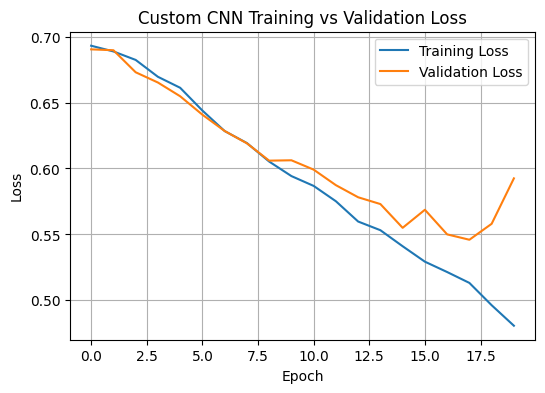

In [221]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history_custom.history['loss'], label='Training Loss')
plt.plot(history_custom.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom CNN Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Plot Confusion Matrix

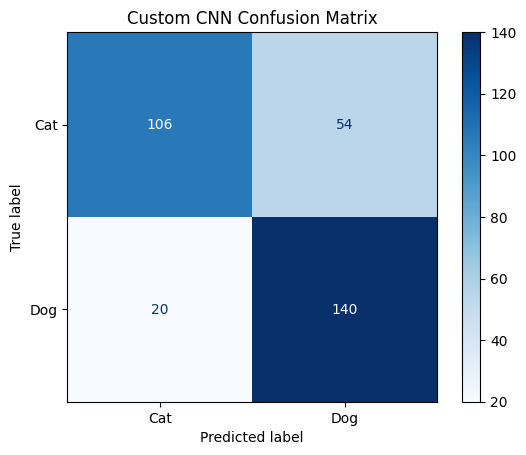

In [222]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_1,
    display_labels=["Cat", "Dog"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Custom CNN Confusion Matrix")
plt.show()

### Show sample predictions

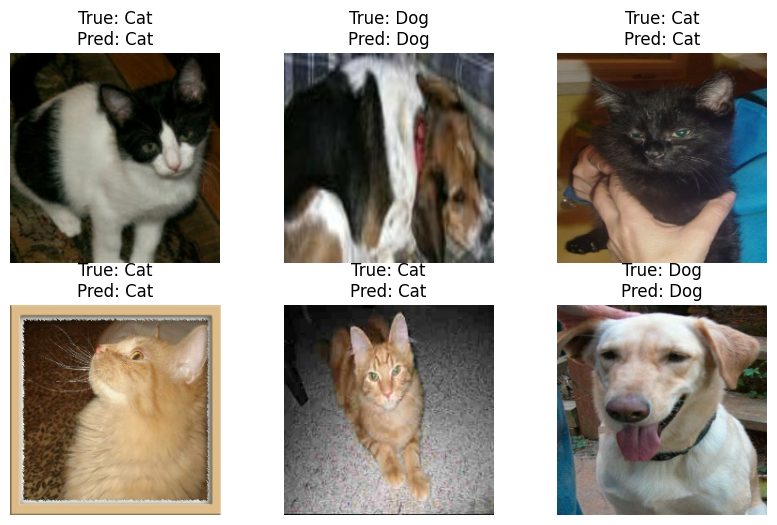

In [223]:
class_names = ["Cat", "Dog"]

plt.figure(figsize=(10,6))

for images, labels in test_ds.take(1):
    preds = custom_cnn.predict(images, verbose=0)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        
        # True label: scalar 0/1
        true_label = class_names[int(labels[i].numpy())]
        
        # Pred label: sigmoid probability → threshold
        pred_label = class_names[int(preds[i][0] >= 0.5)]
        
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")

    plt.show()

## PART 3 : TRANSFER LEARNING

### 3.1 Load Pre-trained Model and Modify Architecture

In [224]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")


TRANSFER LEARNING IMPLEMENTATION


In [225]:
# Choose and load pre-trained model - ResNet18/ResNet50/VGG16/VGG19
pretrained_model_name = "ResNet50"

In [226]:
from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

# Training configuration
tl_learning_rate = 1e-4
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = 'adam'
tl_activation='sigmoid'
tl_loss='binary_crossentropy'

def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    """
    
    # Load pre-trained base model
    if base_model_name == "ResNet50":
        base_model = ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == "VGG16":
        base_model = VGG16(
            weights="imagenet",
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == "VGG19":
        base_model = VGG19(
            weights="imagenet",
            include_top=False,
            input_shape=input_shape
        )
    else:
        raise ValueError("Unsupported model name")
    
    # Freeze base model layers
    base_model.trainable = False

    # Unfreeze top layers of ResNet50
    #for layer in base_model.layers[-30:]:
    #    layer.trainable = True
    
    # Build full model
    model = models.Sequential([
        layers.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),  # MANDATORY
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation=tl_activation)
    ])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=tl_learning_rate),
        loss=tl_loss,
        metrics=['accuracy']
    )
    
    return model


In [227]:
# Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [228]:
frozen_layers = sum([not layer.trainable for layer in transfer_model.layers])
trainable_layers = sum([layer.trainable for layer in transfer_model.layers])

total_parameters = transfer_model.count_params()
trainable_parameters = sum([
    tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights
])

In [229]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 1
Trainable Layers: 4
Total Parameters: 23,850,113
Trainable Parameters: 262,401
Using Global Average Pooling: YES


### 3.2 Train Transfer Learning Model

In [230]:
print("\nTraining Transfer Learning Model...")
# Track training time
tl_start_time = time.time()
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history_tl = transfer_model.fit(
    train_ds,
    epochs=tl_epochs,
    validation_data=test_ds,
    #class_weight=class_weight,
    callbacks=[early_stop]
)
tl_training_time = time.time() - tl_start_time


Training Transfer Learning Model...
Epoch 1/10
     90/Unknown 61s 651ms/step - accuracy: 0.5136 - loss: 0.7251

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


90/90 ━━━━━━━━━━━━━━━━━━━━ 68s 730ms/step - accuracy: 0.5135 - loss: 0.7250 - val_accuracy: 0.6562 - val_loss: 0.6770
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 701ms/step - accuracy: 0.5479 - loss: 0.6894 - val_accuracy: 0.6656 - val_loss: 0.6659
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 702ms/step - accuracy: 0.5865 - loss: 0.6714 - val_accuracy: 0.6719 - val_loss: 0.6588
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 63s 700ms/step - accuracy: 0.5901 - loss: 0.6646 - val_accuracy: 0.6562 - val_loss: 0.6528
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 720ms/step - accuracy: 0.5975 - loss: 0.6590 - val_accuracy: 0.6781 - val_loss: 0.6495
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 722ms/step - accuracy: 0.6053 - loss: 0.6567 - val_accuracy: 0.6562 - val_loss: 0.6460
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 65s 723ms/step - accuracy: 0.6250 - loss: 0.6515 - val_accuracy: 0.6687 - val_loss: 0.6443
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 730ms/step - accuracy: 0.6170 - loss: 0.6509 - val_accuracy: 0.662

In [231]:
# Track initial and final loss
tl_initial_loss = history_tl.history['loss'][0]
tl_final_loss = history_tl.history['loss'][-1]

In [232]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 648.74 seconds
Initial Loss: 0.7159
Final Loss: 0.6487


### 3.3 Evaluate Transfer Learning Model

In [233]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    # True labels (one-hot → class index)
    #y_true.extend(np.argmax(labels.numpy(), axis=1))

    # True labels are already 0/1
    y_true.extend(labels.numpy())
    
    # Model predictions
    preds = transfer_model.predict(images, verbose=0)
   # y_pred.extend(np.argmax(preds, axis=1))

    # Convert probabilities → class labels
    y_pred.extend((preds.flatten() >= 0.5).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm_tl = confusion_matrix(y_true, y_pred)

In [234]:
# Calculate all 4 metrics
tl_accuracy = accuracy_score(y_true, y_pred)
tl_precision = precision_score(y_true, y_pred, average='macro')
tl_recall = recall_score(y_true, y_pred, average='macro')
tl_f1 = f1_score(y_true, y_pred, average='macro')

In [235]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.6562
Precision: 0.6566
Recall:    0.6562
F1-Score:  0.6560


### 3.4 Visualize Transfer Learning Results

#### 3.4.1 Plot training curves (loss and accuracy)

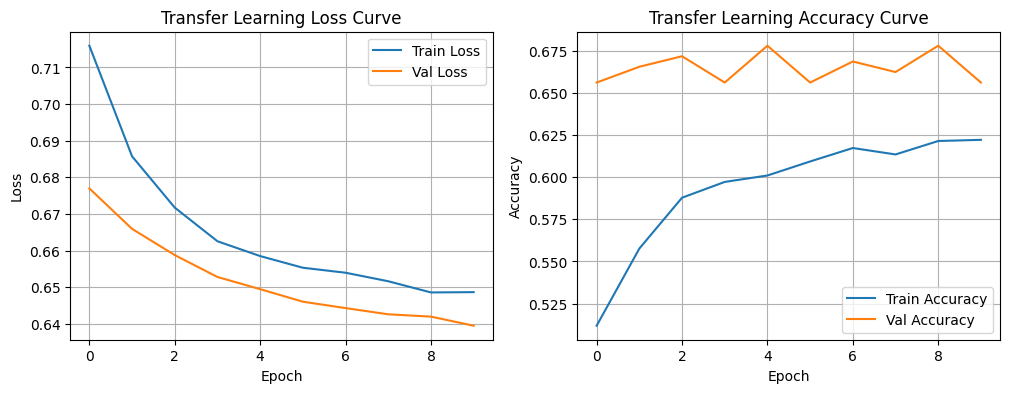

In [236]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history_tl.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Learning Loss Curve')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_tl.history['accuracy'], label='Train Accuracy')
plt.plot(history_tl.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Transfer Learning Accuracy Curve')
plt.legend()
plt.grid(True)

plt.show()


#### 3.4.2 Plot confusion matrix

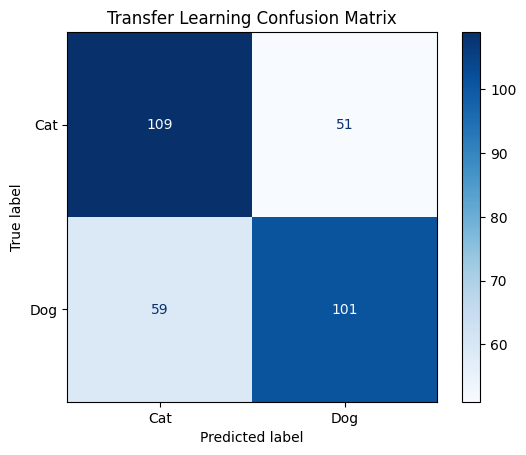

In [237]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_tl,
    display_labels=["Cat", "Dog"]
)

disp.plot(cmap=plt.cm.Blues)
plt.title("Transfer Learning Confusion Matrix")
plt.show()


#### 3.4.3 Show sample predictions

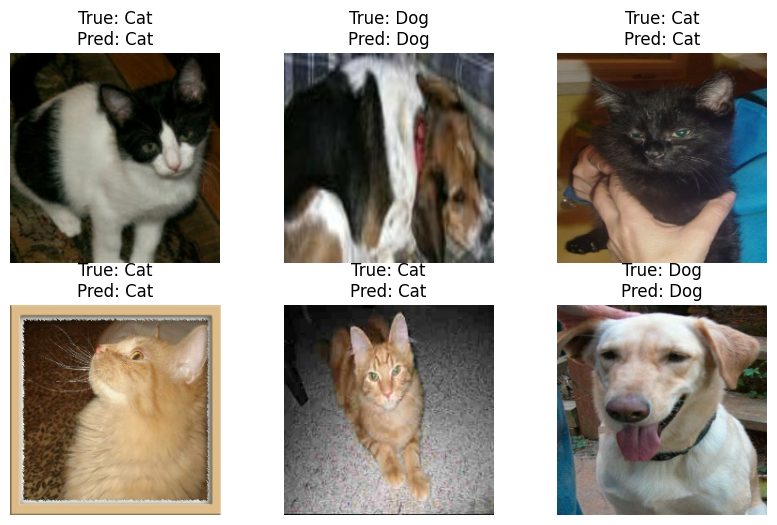

In [238]:
class_names = ["Cat", "Dog"]

plt.figure(figsize=(10,6))

for images, labels in test_ds.take(1):
    preds = transfer_model.predict(images, verbose=0)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        
        # True label: scalar 0/1
        true_label = class_names[int(labels[i].numpy())]
        
        # Pred label: sigmoid probability → threshold
        pred_label = class_names[int(preds[i][0] >= 0.5)]
        
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")

    plt.show()

## PART 4: MODEL COMPARISON AND VISUALIZATION

### 4.1 Metrics Comparison

In [239]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn_total_parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [240]:
print(comparison_df.to_string(index=False))

           Metric    Custom CNN  Transfer Learning
         Accuracy      0.768750           0.656250
        Precision      0.781460           0.656642
           Recall      0.768750           0.656250
         F1-Score      0.766110           0.656035
Training Time (s)    830.507924         648.739768
       Parameters 388673.000000      262401.000000


### 4.2 Visual Comparison

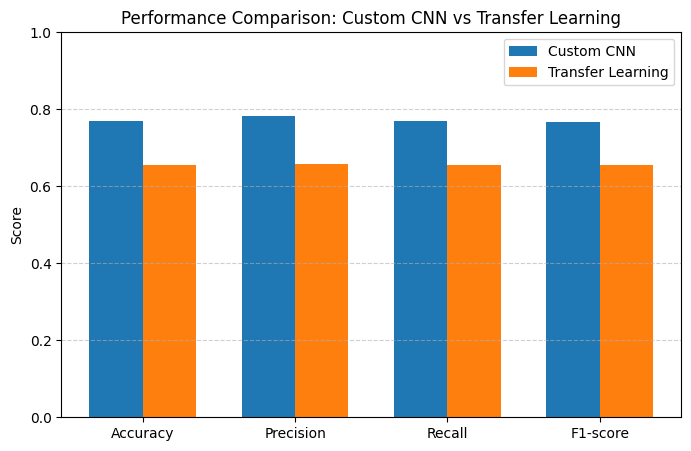

In [241]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

custom_scores = [
    custom_cnn_accuracy,
    custom_cnn_precision,
    custom_cnn_recall,
    custom_cnn_f1
]

tl_scores = [
    tl_accuracy,
    tl_precision,
    tl_recall,
    tl_f1
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, custom_scores, width, label='Custom CNN')
plt.bar(x + width/2, tl_scores, width, label='Transfer Learning')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Performance Comparison: Custom CNN vs Transfer Learning')
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


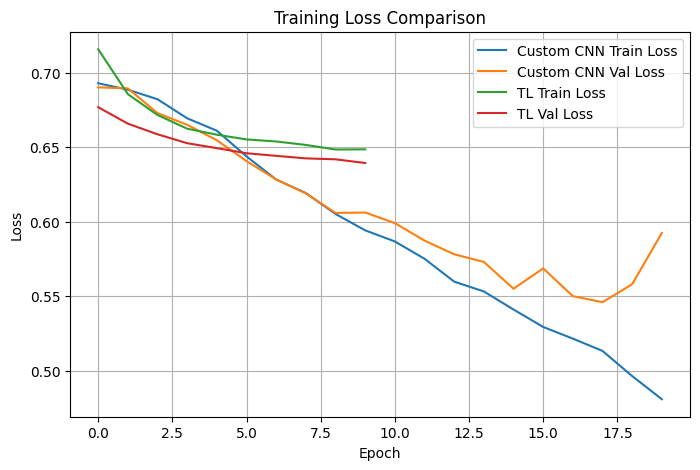

In [242]:
plt.figure(figsize=(8,5))

plt.plot(history_custom.history['loss'], label='Custom CNN Train Loss')
plt.plot(history_custom.history['val_loss'], label='Custom CNN Val Loss')

plt.plot(history_tl.history['loss'], label='TL Train Loss')
plt.plot(history_tl.history['val_loss'], label='TL Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

plt.show()


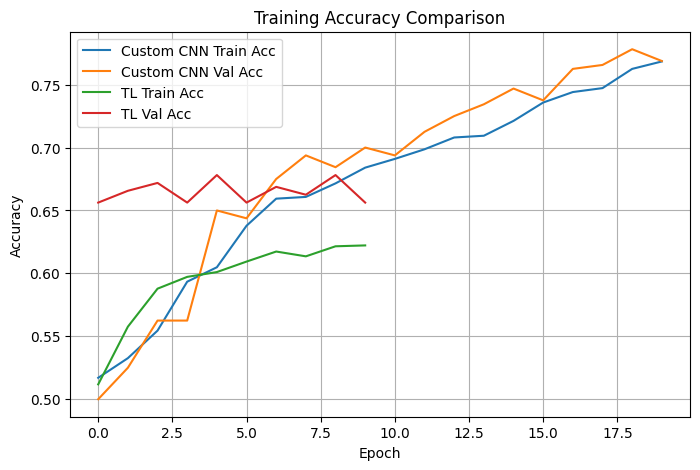

In [243]:
# Accuracy Curves Comparison
plt.figure(figsize=(8,5))

plt.plot(history_custom.history['accuracy'], label='Custom CNN Train Acc')
plt.plot(history_custom.history['val_accuracy'], label='Custom CNN Val Acc')

plt.plot(history_tl.history['accuracy'], label='TL Train Acc')
plt.plot(history_tl.history['val_accuracy'], label='TL Val Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.show()


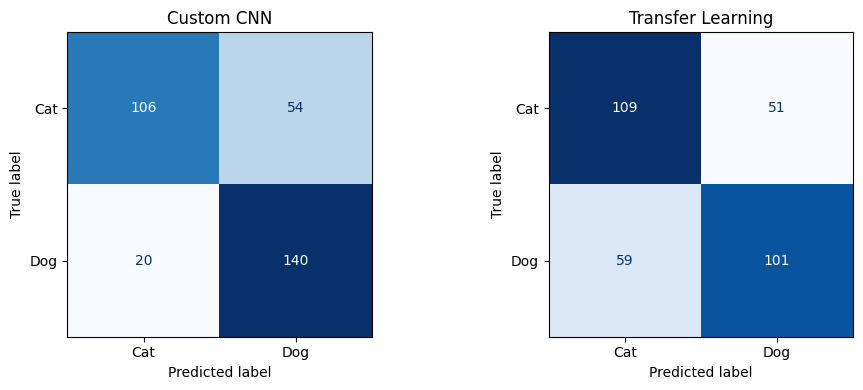

In [244]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(10,4))

disp1 = ConfusionMatrixDisplay(
    confusion_matrix=cm_1,
    display_labels=['Cat', 'Dog']
)
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Custom CNN')

disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_tl,
    display_labels=['Cat', 'Dog']
)
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('Transfer Learning')

plt.tight_layout()
plt.show()


## PART 5 - ANALYSIS

In [245]:
analysis_text = """
The custom CNN achieved higher performance across all evaluation metrics compared to the transfer learning model. Specifically, the custom CNN obtained an accuracy approximately 0.75, while the transfer learning model achieved around 0.65
Pre-training significantly impacts learning behavior. The transfer learning model benefited from pretrained ImageNet features, allowing faster convergence with fewer epochs. However, since the base layers were frozen and fine-tuning was limited, the model could not fully adapt to the target dataset. The custom CNN learned features from scratch, requiring more epochs but achieving better task-specific performance.
Global Average Pooling (GAP) was effective in both models by reducing the number of parameters to overcome overfitting. By replacing fully connected layers, GAP improved generalization while maintaining spatial feature aggregation.
From a computational perspective, the custom CNN required more training time due to a higher number of epochs, whereas the transfer learning model trained faster despite a heavier backbone. This demonstrates that training time depends not only on parameter count but also on architectural complexity.
Overall, transfer learning is advantageous when rapid convergence is required or data is limited, while a well-tuned custom CNN can outperform frozen pretrained models when sufficient training time is available.
"""

In [246]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

ANALYSIS

The custom CNN achieved higher performance across all evaluation metrics compared to the transfer learning model. Specifically, the custom CNN obtained an accuracy approximately 0.75, while the transfer learning model achieved around 0.65
Pre-training significantly impacts learning behavior. The transfer learning model benefited from pretrained ImageNet features, allowing faster convergence with fewer epochs. However, since the base layers were frozen and fine-tuning was limited, the model could not fully adapt to the target dataset. The custom CNN learned features from scratch, requiring more epochs but achieving better task-specific performance.
Global Average Pooling (GAP) was effective in both models by reducing the number of parameters to overcome overfitting. By replacing fully connected layers, GAP improved generalization while maintaining spatial feature aggregation.
From a computational perspective, the custom CNN required more training time due to a higher number of

## PART 6: ASSIGNMENT RESULTS SUMMARY

In [247]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': custom_cnn_layers_conv,  
                'pooling_layers': custom_cnn_layers_pooling,  
                'has_global_average_pooling': True,
                'output_layer': custom_cnn_activation,
                'total_parameters': custom_cnn_total_parameters
            },
            'training_config': {
                'learning_rate': custom_cnn_learning_rate,
                'n_epochs': custom_cnn_epochs,
                'batch_size': custom_cnn_batch_size, 
                'optimizer': custom_cnn_optimizer,
                'loss_function': custom_cnn_loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': tl_loss
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [248]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2, default=str))
    
except Exception as e:
    print(f"\n  ERROR generating results: {e}")
    print("Please ensure all variables are properly defined")   

ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "cats_vs_dogs",
  "dataset_source": "Microsoft Research (Cats vs Dogs) via TensorFlow Datasets",
  "n_samples": 3200,
  "n_classes": 2,
  "samples_per_class": "min: 1600, max: 1600, avg: 1600",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "\nThe chosen Cats vs Dogs dataset is balanced, so accuracy is an appropriate primary metric that fairly represents overall model performance.\n",
  "train_samples": 2880,
  "test_samples": 320,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 4,
      "pooling_layers": 4,
      "has_global_average_pooling": true,
      "output_layer": "sigmoid",
      "total_parameters": 388673
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 20,
      "batch_size": 32,
      "optimizer": "adam",
      "loss_function": "binary_

In [249]:
# Display system information
import platform
import sys
from datetime import datetime

In [250]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here

ENVIRONMENT INFORMATION

  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab
showing your account details in the cell below this one.


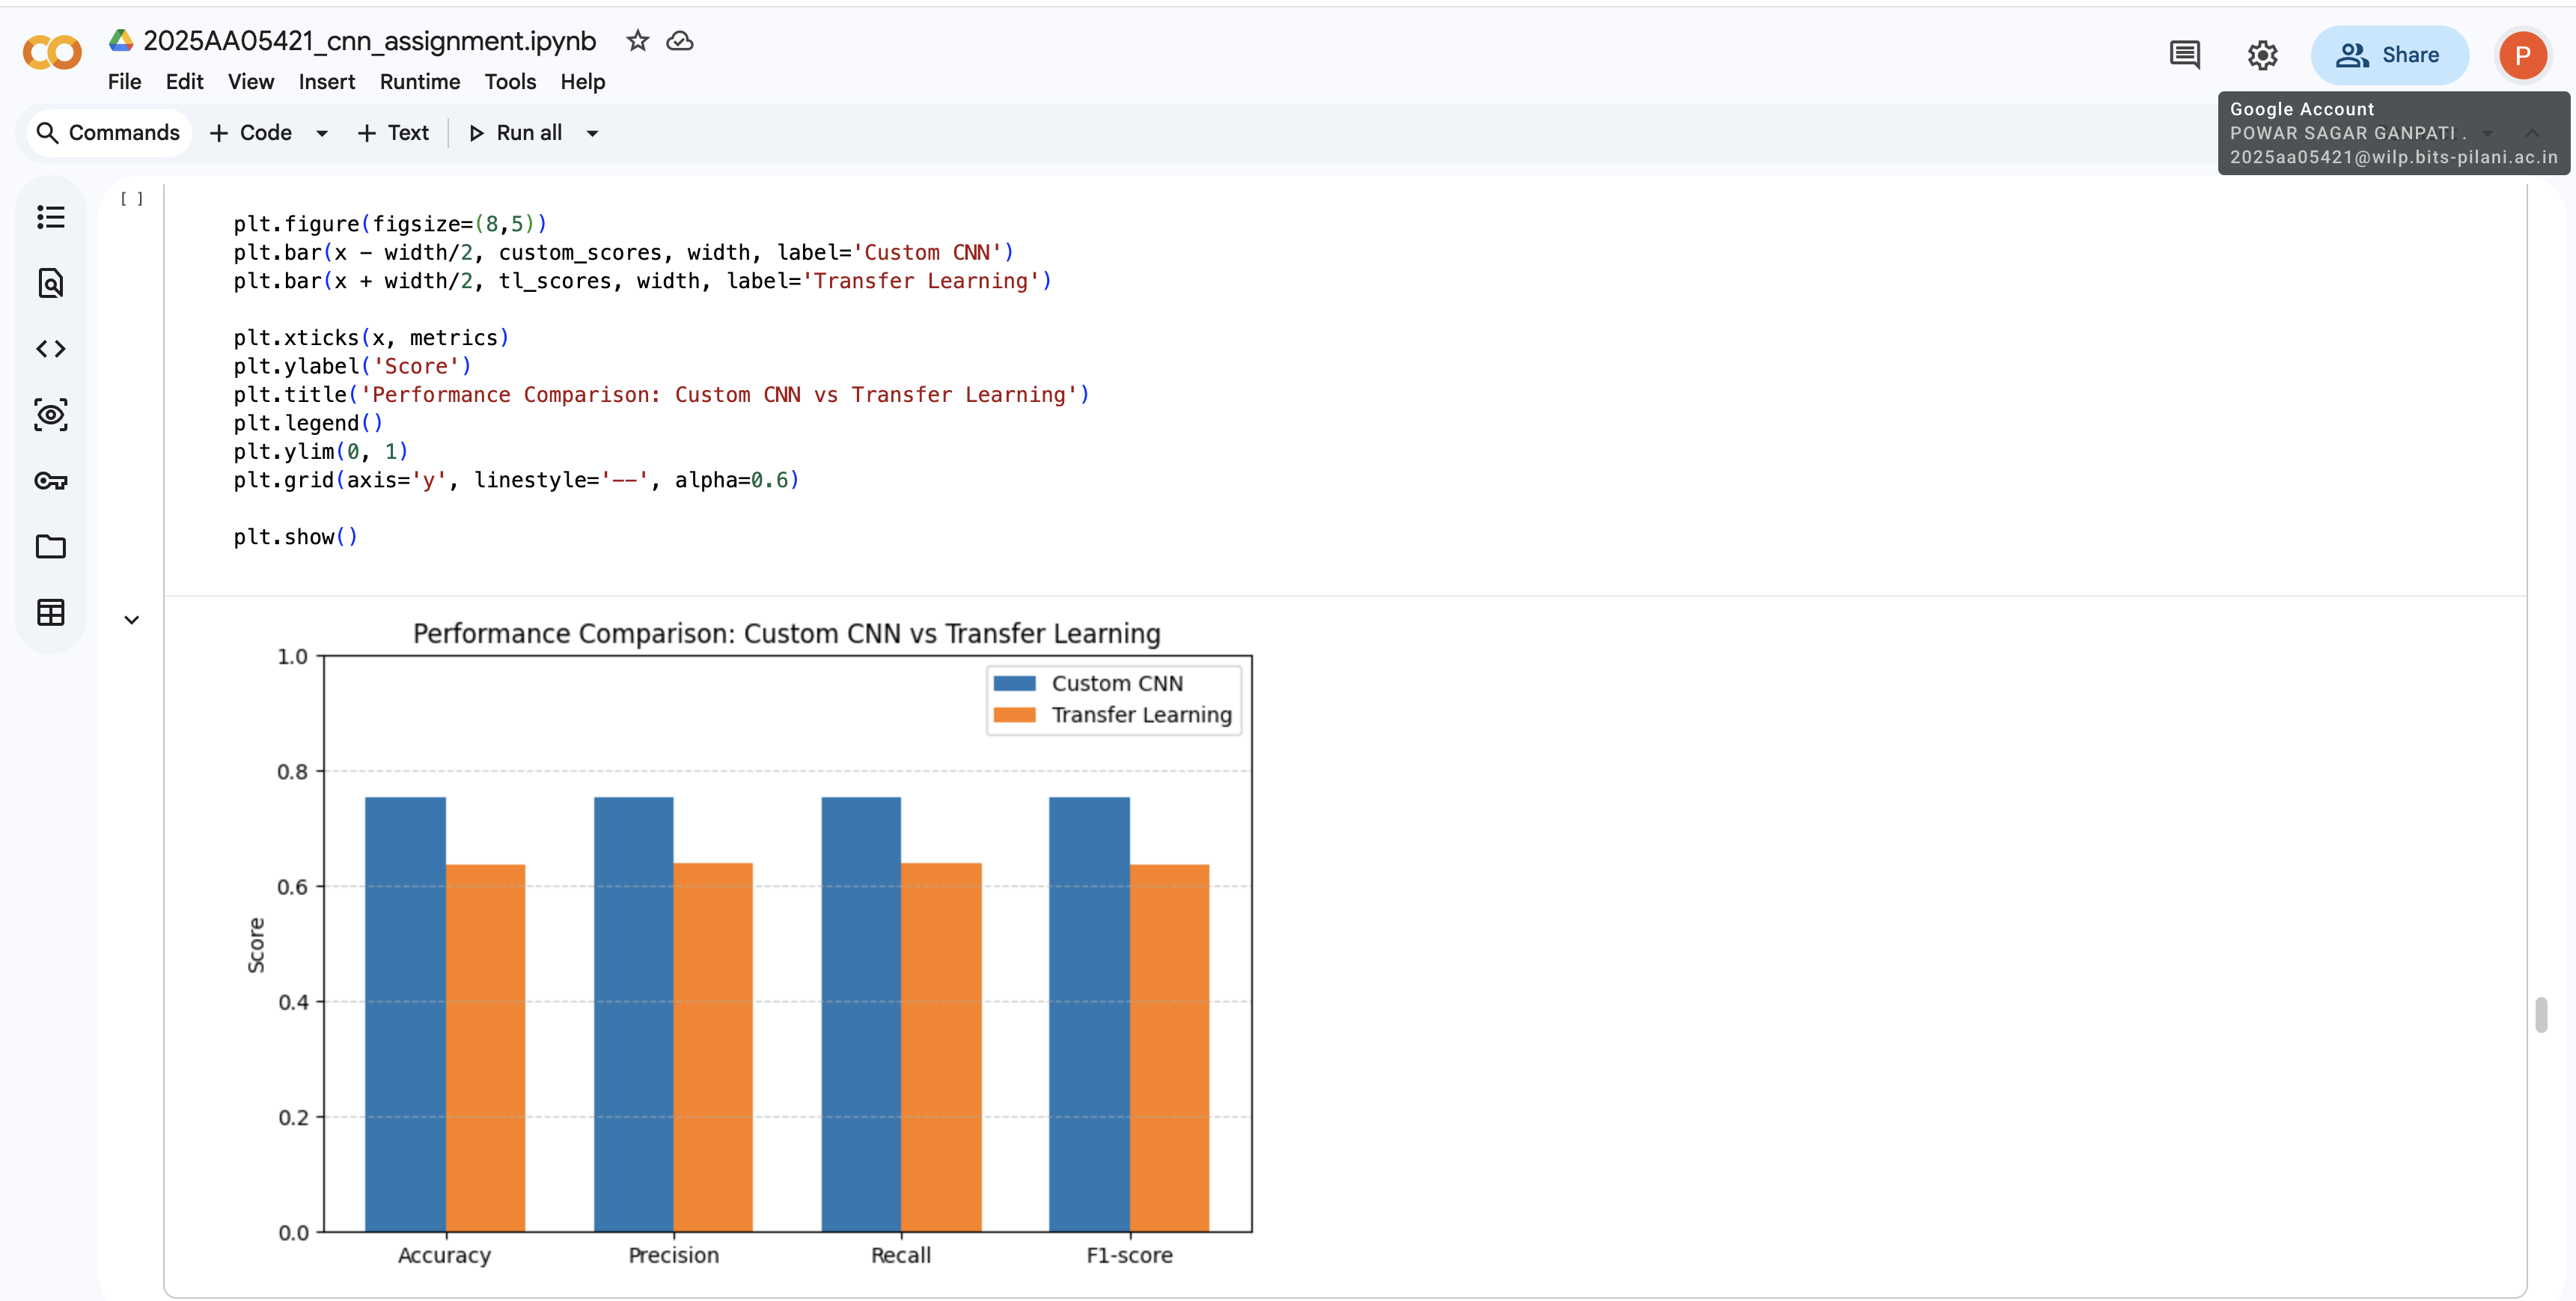